<a href="https://colab.research.google.com/github/lacykaltgr/quant/blob/main/quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup

In [3]:
import pandas as pd
import numpy as np

In [148]:
quant_folder_location = "/content/drive/MyDrive/quant"
county_location_file_path = quant_folder_location + "/agri/minnesota_county_location.csv"
county_agr_prod_file_path = quant_folder_location + "/agri/minnesota_county_yearly_agricultural_production.csv"
station_location_file_path = quant_folder_location + "/weather/minnesota_station_location.csv"

def station_weather_fp(station_name):
  return quant_folder_location + "/weather/minnesota_daily/" + str(station_name) + ".csv"

In [205]:
county_locations_df = pd.read_csv(county_location_file_path)
county_agr_prod_df = pd.read_csv(county_agr_prod_file_path, decimal=',')
station_location_df = pd.read_csv(station_location_file_path)

station_weather_df_list = []
station_codes = np.unique(station_location_df.Code)
for code in station_codes:
  try:
      station_df = pd.read_csv(station_weather_fp(code), header=None, index_col=False, names=["date", "avg", "min", "max", "rain"])
      station_weather_df_list.append(station_df)
  except:
      station_codes.remove(code)
      print(f"Hibás/üres fájl: {code}")

In [91]:
len(station_codes) == len(station_weather_df_list)
station_weather_df_list[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30678 entries, 0 to 30677
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    30678 non-null  object 
 1   avg     14700 non-null  float64
 2   min     30191 non-null  float64
 3   max     30189 non-null  float64
 4   rain    30651 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.2+ MB


# Prepare weather data


In [92]:
for station in station_weather_df_list:
  station["date"] = pd.to_datetime(station["date"])
  station["rain"] = station["rain"].fillna(0)
  station["avg"] = station["avg"].interpolate(method="linear")
  station["min"] = station["min"].interpolate(method="linear")
  station["max"] = station["max"].interpolate(method="linear")

station_weather_df_list[3].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27204 entries, 0 to 27203
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    27204 non-null  datetime64[ns]
 1   avg     27203 non-null  float64       
 2   min     27204 non-null  float64       
 3   max     27204 non-null  float64       
 4   rain    27204 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.0 MB


In [93]:
for i, (station_data, code) in enumerate(zip(station_weather_df_list, station_codes)):
  lat = station_location_df[station_location_df["Code"] == code ].Latitude.values[0]
  lon = station_location_df[station_location_df["Code"] == code ].Longitude.values[0]
  station_weather_df_list[i] = station_data.assign(code = code, lat = lat, lon = lon)

combined_weather_df = pd.concat(station_weather_df_list, axis=0)
combined_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603227 entries, 0 to 53
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    603227 non-null  datetime64[ns]
 1   avg     517292 non-null  float64       
 2   min     602679 non-null  float64       
 3   max     602679 non-null  float64       
 4   rain    603227 non-null  float64       
 5   code    603227 non-null  object        
 6   lat     603227 non-null  float64       
 7   lon     603227 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 41.4+ MB


In [94]:
fillable_weather_df = combined_weather_df[combined_weather_df["min"].notnull() & combined_weather_df["max"].notnull()]
fillable_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602679 entries, 0 to 53
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    602679 non-null  datetime64[ns]
 1   avg     517292 non-null  float64       
 2   min     602679 non-null  float64       
 3   max     602679 non-null  float64       
 4   rain    602679 non-null  float64       
 5   code    602679 non-null  object        
 6   lat     602679 non-null  float64       
 7   lon     602679 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 41.4+ MB


In [108]:
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor

no_missing_weather_df = fillable_weather_df[fillable_weather_df["avg"].notnull()]
no_missing_weather_train_df = no_missing_weather_df.drop("code", axis=1)
no_missing_weather_train_df['year'] = no_missing_weather_train_df['date'].dt.year
no_missing_weather_train_df['month'] = no_missing_weather_train_df['date'].dt.month
no_missing_weather_train_df['day'] = no_missing_weather_train_df['date'].dt.day
no_missing_weather_train_df = no_missing_weather_train_df.drop("date", axis=1)

X_fill_avg = no_missing_weather_train_df.drop("avg", axis=1)
y_fill_avg = no_missing_weather_train_df["avg"]
X_avg_train, X_avg_test, y_avg_train, y_avg_test = train_test_split(X_fill_avg, y_fill_avg, test_size=0.1)
evaluation = [(X_avg_train, y_avg_train), (X_avg_test, y_avg_test)]

model = XGBRegressor(early_stopping_rounds=300)
model.fit(X_avg_train, y_avg_train, eval_set=evaluation, verbose=1)

[0]	validation_0-rmse:9.71722	validation_1-rmse:9.68173
[1]	validation_0-rmse:6.92341	validation_1-rmse:6.90192
[2]	validation_0-rmse:4.97964	validation_1-rmse:4.96960
[3]	validation_0-rmse:3.65094	validation_1-rmse:3.65102
[4]	validation_0-rmse:2.74813	validation_1-rmse:2.75310
[5]	validation_0-rmse:2.13155	validation_1-rmse:2.14388
[6]	validation_0-rmse:1.72605	validation_1-rmse:1.74409
[7]	validation_0-rmse:1.47857	validation_1-rmse:1.50489
[8]	validation_0-rmse:1.31308	validation_1-rmse:1.33893
[9]	validation_0-rmse:1.22201	validation_1-rmse:1.25050
[10]	validation_0-rmse:1.14734	validation_1-rmse:1.17107
[11]	validation_0-rmse:1.09763	validation_1-rmse:1.11802
[12]	validation_0-rmse:1.04918	validation_1-rmse:1.06532
[13]	validation_0-rmse:1.03335	validation_1-rmse:1.05030
[14]	validation_0-rmse:1.00751	validation_1-rmse:1.02278
[15]	validation_0-rmse:0.98822	validation_1-rmse:1.00159
[16]	validation_0-rmse:0.98352	validation_1-rmse:0.99752
[17]	validation_0-rmse:0.97556	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=300,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [110]:
missing_avg_weather_df = fillable_weather_df[fillable_weather_df["avg"].isnull()]
missing_avg_weather_prediction_X_df = missing_avg_weather_df.drop(["avg", "code"], axis=1)
missing_avg_weather_prediction_X_df['year'] = missing_avg_weather_prediction_X_df['date'].dt.year
missing_avg_weather_prediction_X_df['month'] = missing_avg_weather_prediction_X_df['date'].dt.month
missing_avg_weather_prediction_X_df['day'] = missing_avg_weather_prediction_X_df['date'].dt.day
missing_avg_weather_prediction_X_df = missing_avg_weather_prediction_X_df.drop("date", axis=1)

missing_avg_weather_prediction_y_df = model.predict(missing_avg_weather_prediction_X_df)
missing_avg_weather_df["avg"] = missing_avg_weather_prediction_y_df

<ipython-input-110-a38116bb8b4f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_avg_weather_df["avg"] = missing_avg_weather_prediction_y_df


In [111]:
missing_avg_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85387 entries, 0 to 33373
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    85387 non-null  datetime64[ns]
 1   avg     85387 non-null  float32       
 2   min     85387 non-null  float64       
 3   max     85387 non-null  float64       
 4   rain    85387 non-null  float64       
 5   code    85387 non-null  object        
 6   lat     85387 non-null  float64       
 7   lon     85387 non-null  float64       
dtypes: datetime64[ns](1), float32(1), float64(5), object(1)
memory usage: 5.5+ MB


In [113]:
weather_df = pd.concat([missing_avg_weather_df, no_missing_weather_df], axis=0)
weather_df = weather_df.drop("code", axis=1)
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602679 entries, 0 to 53
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    602679 non-null  datetime64[ns]
 1   avg     602679 non-null  float64       
 2   min     602679 non-null  float64       
 3   max     602679 non-null  float64       
 4   rain    602679 non-null  float64       
 5   lat     602679 non-null  float64       
 6   lon     602679 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 36.8 MB


# Prepare crop data

In [191]:
county_agr_prod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52587 entries, 0 to 56267
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          52587 non-null  int64  
 1   County                        52587 non-null  object 
 2   Commodity                     52587 non-null  object 
 3   Crop                          52587 non-null  object 
 4   ACRES HARVESTED               52585 non-null  float64
 5   PRODUCTION, MEASURED IN BU    22806 non-null  float64
 6   YIELD, MEASURED IN BU / ACRE  33232 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 3.2+ MB


In [212]:
county_agr_prod_df = county_agr_prod_df.rename(
    columns={'ACRES HARVESTED': 'acres', 
             'PRODUCTION, MEASURED IN BU': 'production', 
             'YIELD, MEASURED IN BU / ACRE': 'yield'})
county_agr_prod_df['acres'] = pd.to_numeric(county_agr_prod_df['acres'].astype(str).str.replace(',', '.'), errors='coerce')
county_agr_prod_df['production'] = pd.to_numeric(county_agr_prod_df['production'].astype(str).str.replace(',', '.'), errors='coerce')
county_agr_prod_df['yield'] = pd.to_numeric(county_agr_prod_df['yield'].astype(str).str.replace(',', '.'), errors='coerce')
county_agr_prod_df = county_agr_prod_df[county_agr_prod_df['acres'].notnull() | county_agr_prod_df['production'].notnull() | county_agr_prod_df['yield'].notnull()]

corn_df = county_agr_prod_df[county_agr_prod_df["Crop"] == "CORN, GRAIN"] #| county_agr_prod_df["Crop"] == "CORN, SILAGE"]
oat_df = county_agr_prod_df[county_agr_prod_df["Crop"] == "OATS"]
soybean_df = county_agr_prod_df[county_agr_prod_df["Crop"] == "SOYBEANS"]

In [184]:
np.unique(county_agr_prod_df['Crop'])

array(['BARLEY', 'BEANS, DRY EDIBLE, INCL CHICKPEAS', 'CANOLA',
       'CORN, GRAIN', 'CORN, SILAGE', 'FLAXSEED', 'HAY',
       'HAY, (EXCL ALFALFA)', 'HAY, ALFALFA', 'OATS', 'RYE', 'SOYBEANS',
       'SUGARBEETS', 'SUNFLOWER', 'SUNFLOWER, NON', 'SUNFLOWER, OIL TYPE',
       'WHEAT', 'WHEAT, SPRING, (EXCL DURUM)', 'WHEAT, SPRING, DURUM',
       'WHEAT, WINTER'], dtype=object)

In [213]:
corn_df[corn_df['acres'].isna()]

,Year,County,Commodity,Crop,acres,production,yield
48206,2005,OTHER (COMBINED) COUNTIES,CORN,"CORN, GRAIN",NaN,NaN,0.0


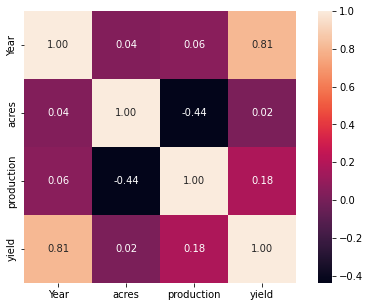

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns

plot = corn_df

plot = plot[plot['acres'].notnull() & plot['production'].notnull() & plot['yield'].notnull()]
numeric_columns = plot.select_dtypes(include=['int64', 'float64']).columns

cm = np.corrcoef(plot[numeric_columns].values.T)
fig = plt.gcf()
fig.set_size_inches(8, 5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=numeric_columns.values, xticklabels=numeric_columns.values)

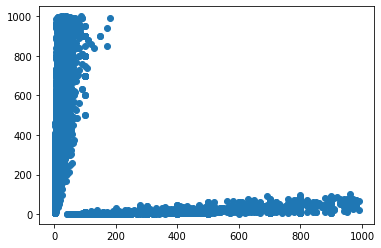

In [215]:
plt.scatter(county_agr_prod_df['acres'], county_agr_prod_df['production'])
plt.show()

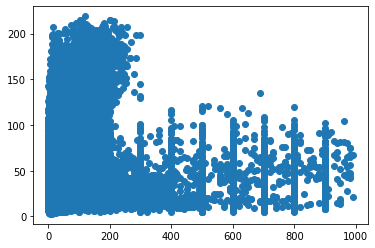

In [216]:
plt.scatter(county_agr_prod_df['acres'], county_agr_prod_df['yield'])
plt.show()

In [ ]:
# input: 1881-2022...2022 napi időjárás adatok
# output: 2006-2022...2022 éves crop yield

# - az adott év adatai a bemenet, a dátummal együtt (~5000 example)
# - sorozatos rendszer egészen az elejétől - túl nagy az intevallumok szórása (?)
# - sorozatos rendszer az előző párról - lehet megéri, de valszeg nem

# mindenképp össze kéne vonni a napokat hetekké vagy hónapokká
# utána kéne nézni ennek hogyan van értelme
# mit kezdünk OTHER (COMBINED) COUNTIES-al
# hogyan kötjük össze az időjárást a crop-al